In [1]:
import pandas as pd
import urllib.parse

url_base = 'https://raw.githubusercontent.com/parorrr/04/main/data/variable/ft/'

files = [
    '不健康率.csv',
    '人口密度3.csv',
    '失业率和就业率.csv',
    '树木覆盖率.csv',
    '贫困率.csv'
]

merged_data = pd.DataFrame()

for file_name in files:
    file_url = f"{url_base}{urllib.parse.quote(file_name)}"
    try:
        df = pd.read_csv(file_url)
        
        # 如果是第一个文件，直接赋值给merged_data
        if merged_data.empty:
            merged_data = df
        else:
            # 使用suffixes参数来避免列名冲突
            merged_data = pd.merge(merged_data, df, on='ward_code', how='left', suffixes=('', '_dup'))
            
        print(f"Loaded {file_name} successfully.")
        
    except Exception as e:
        print(f"Failed to load {file_name}. Error: {e}")

merged_data = merged_data.loc[:,~merged_data.columns.duplicated()]

print(merged_data.head())
print(merged_data.info())

merged_data.to_csv('merged_data.csv', index=False)


Loaded 不健康率.csv successfully.
Loaded 人口密度3.csv successfully.
Loaded 失业率和就业率.csv successfully.
Loaded 树木覆盖率.csv successfully.
Loaded 贫困率.csv successfully.
                NAME  bad health rate  ward_code  Observation  \
0     City of London         0.026832  E09000001       2975.0   
1              Abbey         0.034561  E05014053       8642.9   
2             Alibon         0.051407  E05014054       6991.8   
3  Barking Riverside         0.033201  E05014055       2246.8   
4               Beam         0.042350  E05014056       3106.2   

            NAME_dup  Unemployed  Economically active rate percentage  \
0     City of London    0.035313                  0.708385        NaN   
1              Abbey    0.048442                  0.692751     11.23%   
2             Alibon    0.045455                  0.652588      6.10%   
3  Barking Riverside    0.052296                  0.719977      3.16%   
4               Beam    0.048684                  0.641612      5.08%   

   deprived rate

In [2]:
import pandas as pd

data = pd.read_csv('merged_data.csv')

data.drop(columns=['NAME_dup'], inplace=True)

data['percentage'] = data['percentage'].str.rstrip('%').astype('float') / 100

if data.isnull().any().any():
    
    data['percentage'].fillna(data['percentage'].mean(), inplace=True)

for col in data.select_dtypes(include=['float']):
    data[col] = pd.to_numeric(data[col], downcast='float')

assert data['ward_code'].duplicated().sum() == 0, "There are duplicate ward codes!"

data.to_csv('cleaned_data.csv', index=False)

print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NAME                      680 non-null    object 
 1   bad health rate           680 non-null    float32
 2   ward_code                 680 non-null    object 
 3   Observation               680 non-null    float64
 4   Unemployed                680 non-null    float32
 5   Economically active rate  680 non-null    float32
 6   percentage                680 non-null    float32
 7   deprived rate             680 non-null    float32
dtypes: float32(5), float64(1), object(2)
memory usage: 29.3+ KB
None


In [3]:
import pandas as pd


raw_url_collisions = 'https://raw.githubusercontent.com/parorrr/04/main/data/variable/ft/MPS%20Ward%20Level%20Crime.csv'

try:
    data = pd.read_csv(raw_url_collisions)
    crime_mapping = {
        'ARSON AND CRIMINAL DAMAGE': 'Property Crime',
        'BURGLARY': 'Property Crime',
        'DRUG OFFENCES': 'Public Order Offences',
        'MISCELLANEOUS CRIMES AGAINST SOCIETY': 'Public Order Offences',
        'POSSESSION OF WEAPONS': 'Violent Crime',
        'PUBLIC ORDER OFFENCES': 'Public Order Offences',
        'ROBBERY': 'Violent Crime',
        'SEXUAL OFFENCES': 'Violent Crime',
        'THEFT': 'Property Crime',
        'VEHICLE OFFENCES': 'Property Crime',
        'VIOLENCE AGAINST THE PERSON': 'Violent Crime'
    }

    data['Crime Category'] = data['MajorText'].map(crime_mapping)

    result = data.groupby(['WardName', 'WardCode', 'Crime Category']).agg({'2021': 'sum'}).reset_index()

    total_crimes = result.groupby(['WardName', 'WardCode']).agg(Total_Crimes=('2021', 'sum')).reset_index()

    pivot_df = result.pivot_table(index=['WardName', 'WardCode'], columns='Crime Category', values='2021', fill_value=0).reset_index()
    pivot_df.columns.name = None  

    pivot_df = pivot_df.merge(total_crimes, on=['WardName', 'WardCode'], how='left')

    print(pivot_df.head())

    pivot_df.to_csv('aggregated_crime_data_by_category_with_total.csv', index=False)

except Exception as e:
    print(f"An error occurred: {e}")


     WardName   WardCode  Property Crime  Public Order Offences  \
0       Abbey  E05013810           251.0                   99.0   
1       Abbey  E05014053           805.0                  202.0   
2  Abbey Road  E05013792           370.0                   97.0   
3  Abbey Wood  E05014072           565.0                  267.0   
4    Abingdon  E05009388           437.0                  119.0   

   Violent Crime  Total_Crimes  
0          279.0           629  
1          381.0          1388  
2          199.0           666  
3          661.0          1493  
4          246.0           802  


In [4]:
import pandas as pd

crime_summary = data.groupby('WardCode').agg({
    '2021': 'sum'  
}).reset_index()

merged_data = pd.merge(crime_summary, pivot_df, on='WardCode', how='inner')

cleaned_data = merged_data.drop(columns=['2021'])

print(cleaned_data.head())
print(cleaned_data.info())

cleaned_data.to_csv('final_aggregated_data.csv', index=False)


    WardCode                 WardName  Property Crime  Public Order Offences  \
0  E05009317            Bethnal Green          1102.0                  429.0   
1  E05009318  Blackwall & Cubitt Town           681.0                  238.0   
2  E05009319                 Bow East          1020.0                  296.0   
3  E05009320                 Bow West           672.0                  221.0   
4  E05009321            Bromley North           532.0                  165.0   

   Violent Crime  Total_Crimes  
0          900.0          2431  
1          559.0          1478  
2          600.0          1916  
3          494.0          1387  
4          461.0          1158  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   WardCode               680 non-null    object 
 1   WardName               680 non-null    object 
 2   Prop

In [5]:
import pandas as pd

crime_data = pd.read_csv('final_aggregated_data.csv')
demographic_data = pd.read_csv('cleaned_data.csv')

crime_data['WardCode'] = crime_data['WardCode'].astype(str)
demographic_data['ward_code'] = demographic_data['ward_code'].astype(str)

full_data = pd.merge(crime_data, demographic_data, left_on='WardCode', right_on='ward_code', how='inner')

full_data.drop(columns=['ward_code'], inplace=True)
full_data = full_data.drop(columns=['NAME'])
print(full_data.head())
print(full_data.info())

full_data.to_csv('final_merged_data.csv', index=False)


    WardCode                 WardName  Property Crime  Public Order Offences  \
0  E05009317            Bethnal Green          1102.0                  429.0   
1  E05009318  Blackwall & Cubitt Town           681.0                  238.0   
2  E05009319                 Bow East          1020.0                  296.0   
3  E05009320                 Bow West           672.0                  221.0   
4  E05009321            Bromley North           532.0                  165.0   

   Violent Crime  Total_Crimes  bad health rate  Observation  Unemployed  \
0          900.0          2431         0.052312      17378.0    0.044813   
1          559.0          1478         0.029785      15881.7    0.049781   
2          600.0          1916         0.048989      10472.5    0.048706   
3          494.0          1387         0.053818      10203.2    0.035462   
4          461.0          1158         0.056488      19297.5    0.058340   

   Economically active rate  percentage  deprived rate  
0    

In [6]:
import pandas as pd

url_base = 'https://raw.githubusercontent.com/parorrr/04/main/data/variable/ft/'

files = [
    'LondonVegetationCoverage.csv',
    'LondonGreenCoveragePercentage2.csv',
    'final.csv',
]

data_list = []
for file_name in files:
    file_url = f"{url_base}{file_name}"
    df = pd.read_csv(file_url)
    if 'WD22CD' in df.columns:
        df.rename(columns={'WD22CD': 'WardCode'}, inplace=True)
    data_list.append(df)

from functools import reduce
merged_data = reduce(lambda left, right: pd.merge(left, right, on='WardCode', how='inner'), data_list)

full_data = pd.read_csv('final_merged_data.csv')

full_data['WardCode'] = full_data['WardCode'].astype(str)
merged_data['WardCode'] = merged_data['WardCode'].astype(str)

final_merged_data = pd.merge(full_data, merged_data, on='WardCode', how='inner')

final_merged_data = final_merged_data.drop(columns=['WD22NM_x','WD22NM_y','NAME',])

final_merged_data.rename(columns={'percentage': 'tree_cover_percentage'}, inplace=True)
final_merged_data.rename(columns={'Observation': 'population_density'}, inplace=True)
final_merged_data.rename(columns={'Property Crime': 'Property_Crime'}, inplace=True)
final_merged_data.rename(columns={'Public Order Offences': 'Public_Order_Offences'}, inplace=True)
final_merged_data.rename(columns={'Violent Crime': 'Violent_Crime'}, inplace=True)
final_merged_data.rename(columns={'bad health rate': 'bad_health_rate'}, inplace=True)
final_merged_data.rename(columns={'Economically active rate': 'Economically_active_rate'}, inplace=True)
final_merged_data.rename(columns={'deprived rate': 'deprived_rate'}, inplace=True)
final_merged_data.rename(columns={'WardCode': 'WD22CD'}, inplace=True)

print(final_merged_data.head())
print(final_merged_data.info())
final_merged_data.to_csv('comprehensive_final_data.csv', index=False)



      WD22CD                 WardName  Property_Crime  Public_Order_Offences  \
0  E05009317            Bethnal Green          1102.0                  429.0   
1  E05009318  Blackwall & Cubitt Town           681.0                  238.0   
2  E05009319                 Bow East          1020.0                  296.0   
3  E05009320                 Bow West           672.0                  221.0   
4  E05009321            Bromley North           532.0                  165.0   

   Violent_Crime  Total_Crimes  bad_health_rate  population_density  \
0          900.0          2431         0.052312             17378.0   
1          559.0          1478         0.029785             15881.7   
2          600.0          1916         0.048989             10472.5   
3          494.0          1387         0.053818             10203.2   
4          461.0          1158         0.056488             19297.5   

   Unemployed  Economically_active_rate  tree_cover_percentage  deprived_rate  \
0    0.0448

In [7]:
final_merged_data['green_percentage_GLA'] = final_merged_data['green_percentage_GLA'].str.rstrip('%').astype(float) / 100



In [8]:
print(final_merged_data.dtypes)  # 打印数据类型

WD22CD                       object
WardName                     object
Property_Crime              float64
Public_Order_Offences       float64
Violent_Crime               float64
Total_Crimes                  int64
bad_health_rate             float64
population_density          float64
Unemployed                  float64
Economically_active_rate    float64
tree_cover_percentage       float64
deprived_rate               float64
percentage_NDVI             float64
percentage_RF               float64
green_percentage_GLA        float64
dtype: object


In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

print(final_merged_data.describe()) 
print(final_merged_data.info())     

       Property_Crime  Public_Order_Offences  Violent_Crime  Total_Crimes  \
count      680.000000             680.000000     680.000000    680.000000   
mean       572.988235             173.657353     421.195588   1167.841176   
std        665.235458             221.558648     424.738351   1242.578893   
min         81.000000              22.000000      61.000000    177.000000   
25%        330.000000              92.000000     248.000000    676.750000   
50%        461.500000             147.500000     371.000000    998.000000   
75%        636.500000             204.000000     517.000000   1338.750000   
max      11641.000000            4950.000000    9460.000000  23482.000000   

       bad_health_rate  population_density  Unemployed  \
count       680.000000          680.000000  680.000000   
mean          0.042476         8703.042794    0.040503   
std           0.010607         4863.122218    0.009871   
min           0.012970          171.500000    0.018286   
25%           0.

In [10]:
final_merged_data.to_csv('final_merged_data.csv', index=False)

In [11]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

data = pd.read_csv('final_merged_data.csv')

variables = data[['bad_health_rate', 'population_density', 'Unemployed',
                  'Economically_active_rate', 'deprived_rate']]

variables = variables.assign(const=1)

vif_data = pd.DataFrame()
vif_data['feature'] = variables.columns

vif_data['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

print(vif_data)


                    feature         VIF
0           bad_health_rate    2.639407
1        population_density    1.489971
2                Unemployed    3.737091
3  Economically_active_rate    2.243549
4             deprived_rate    4.710465
5                     const  568.298689


In [12]:
import pandas as pd

data = pd.read_csv('final_merged_data.csv')

variables = ['bad_health_rate', 'population_density', 'Unemployed', 'Economically_active_rate', 'deprived_rate']
summary_stats = {
    'Variable': variables,
    'Mean': [data[var].mean() for var in variables],
    'Min': [data[var].min() for var in variables],
    'Max': [data[var].max() for var in variables],
    'Standard Deviation': [data[var].std() for var in variables]
}

summary_table = pd.DataFrame(summary_stats)

print(summary_table)


                   Variable         Mean         Min           Max  \
0           bad_health_rate     0.042476    0.012970      0.099820   
1        population_density  8703.042794  171.500000  26449.100000   
2                Unemployed     0.040503    0.018286      0.070304   
3  Economically_active_rate     0.661599    0.479936      0.843121   
4             deprived_rate     0.519669    0.290229      0.744691   

   Standard Deviation  
0            0.010607  
1         4863.122218  
2            0.009871  
3            0.051221  
4            0.089508  


In [13]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [14]:
from prettytable import PrettyTable
import pandas as pd

data = pd.read_csv('final_merged_data.csv')

variables = ['bad_health_rate', 'population_density', 'Unemployed', 'Economically_active_rate', 'deprived_rate']
stats = ['Mean', 'Min', 'Max', 'Standard Deviation']

table = PrettyTable()
table.field_names = ['Variable'] + stats

for var in variables:
    row = [var] + [data[var].mean(), data[var].min(), data[var].max(), data[var].std()]
    table.add_row(row)

print(table)


+--------------------------+----------------------+-------------+------------+----------------------+
|         Variable         |         Mean         |     Min     |    Max     |  Standard Deviation  |
+--------------------------+----------------------+-------------+------------+----------------------+
|     bad_health_rate      | 0.042475715264705886 | 0.012969999 | 0.09981991 | 0.010606791223092512 |
|    population_density    |  8703.042794117646   |    171.5    |  26449.1   |   4863.12221767177   |
|        Unemployed        | 0.040502602027941176 | 0.018285507 | 0.0703035  | 0.009870844067578117 |
| Economically_active_rate |  0.6615986724852941  |  0.4799361  | 0.84312135 | 0.051221210689374595 |
|      deprived_rate       |  0.5196692351911765  |  0.2902287  | 0.7446905  | 0.08950786841301933  |
+--------------------------+----------------------+-------------+------------+----------------------+


In [15]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

data = pd.read_csv('final_merged_data.csv')

variables = data[['tree_cover_percentage', 'percentage_NDVI', 'percentage_RF', 'green_percentage_GLA']]

variables = variables.assign(const=1)

vif_data = pd.DataFrame()
vif_data['feature'] = variables.columns

vif_data['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

print(vif_data)


                 feature        VIF
0  tree_cover_percentage   2.153746
1        percentage_NDVI  41.367293
2          percentage_RF  51.285300
3   green_percentage_GLA   7.745794
4                  const   7.759220


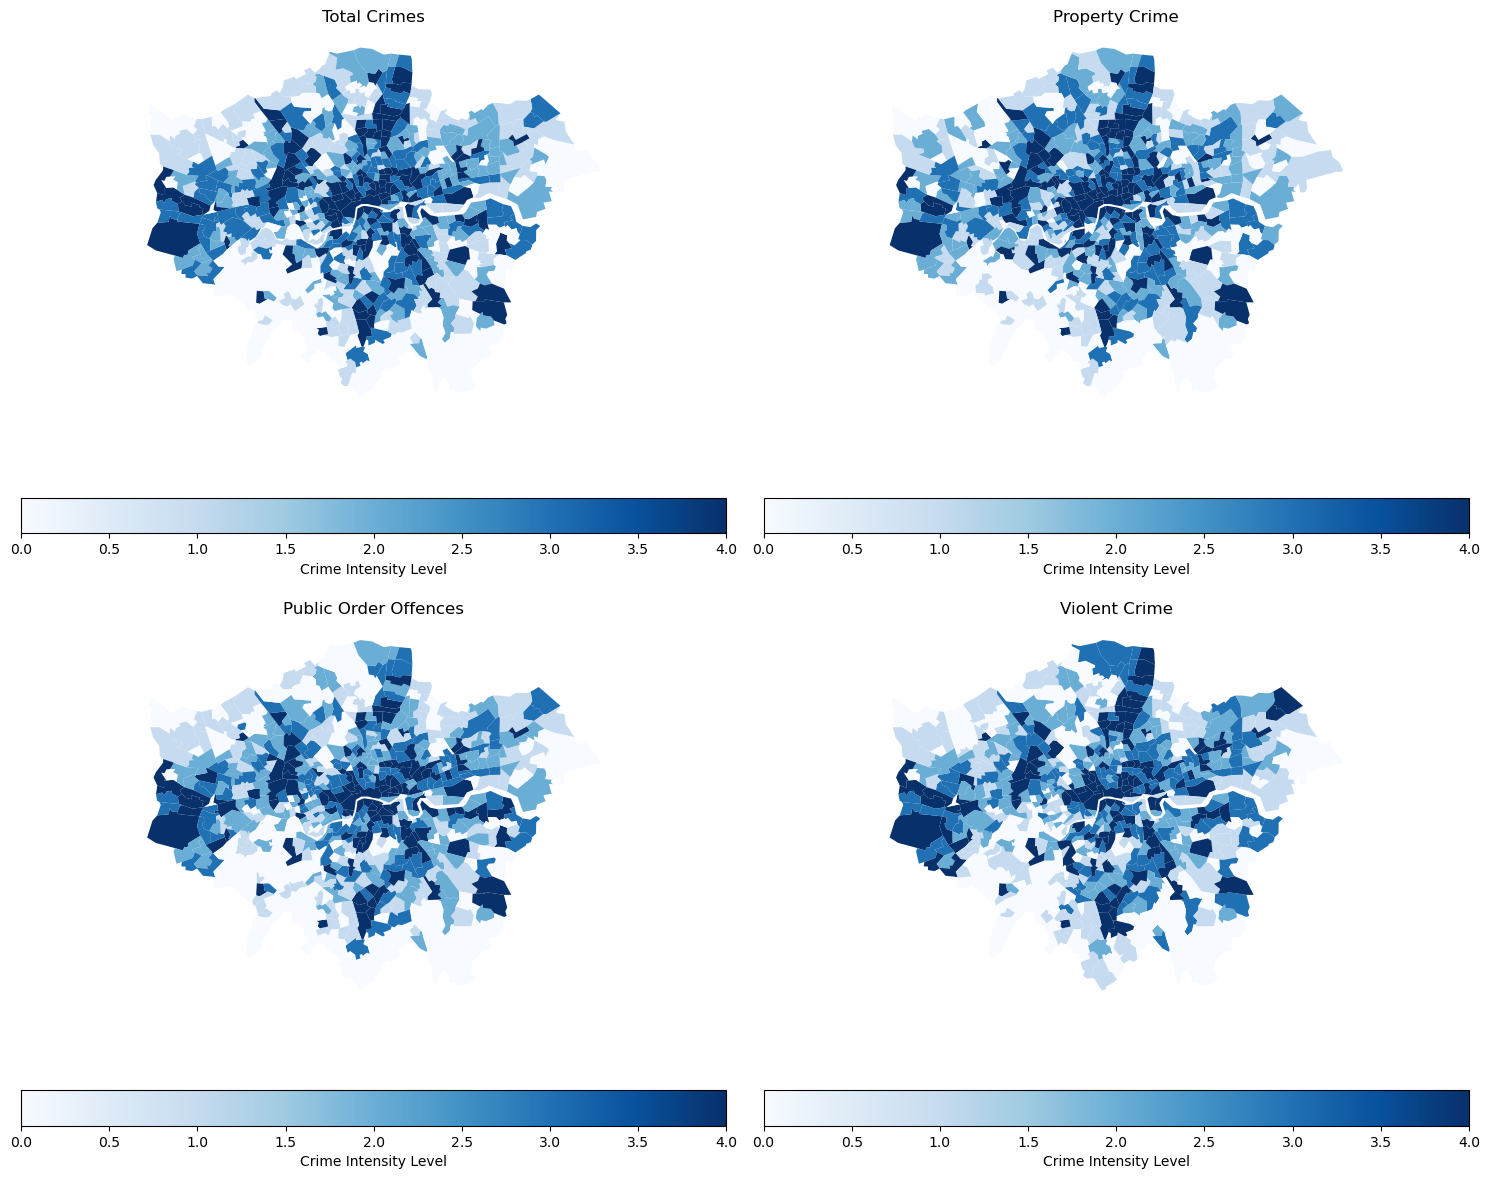

In [16]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

url = "https://raw.githubusercontent.com/parorrr/04/main/data/2.shp"
gdf = gpd.read_file(url)
data = pd.read_csv('final_merged_data.csv')
merged_data = gdf.merge(data, on='WD22CD')

merged_data1 = gdf.merge(data, on='WD22CD', suffixes=('_gdf', '_csv'))

merged_data.drop(columns='geometry').to_csv('merged_data_with_attributes.csv', index=False)


def categorize_crimes(data):
    bins = pd.qcut(data, 5, labels=False, duplicates='drop')
    return bins

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

titles = ['Total Crimes', 'Property Crime', 'Public Order Offences', 'Violent Crime']
columns = ['Total_Crimes', 'Property_Crime', 'Public_Order_Offences', 'Violent_Crime']

for ax, title, column in zip(axes.flatten(), titles, columns):
    
    merged_data['crime_level'] = categorize_crimes(merged_data[column])
    merged_data.plot(column='crime_level', ax=ax, cmap='Blues', legend=True,
                     legend_kwds={'label': "Crime Intensity Level",
                                  'orientation': "horizontal"})
    ax.set_title(title)
    ax.set_axis_off()

plt.tight_layout()
plt.savefig('crime_maps.png')  
plt.show() 



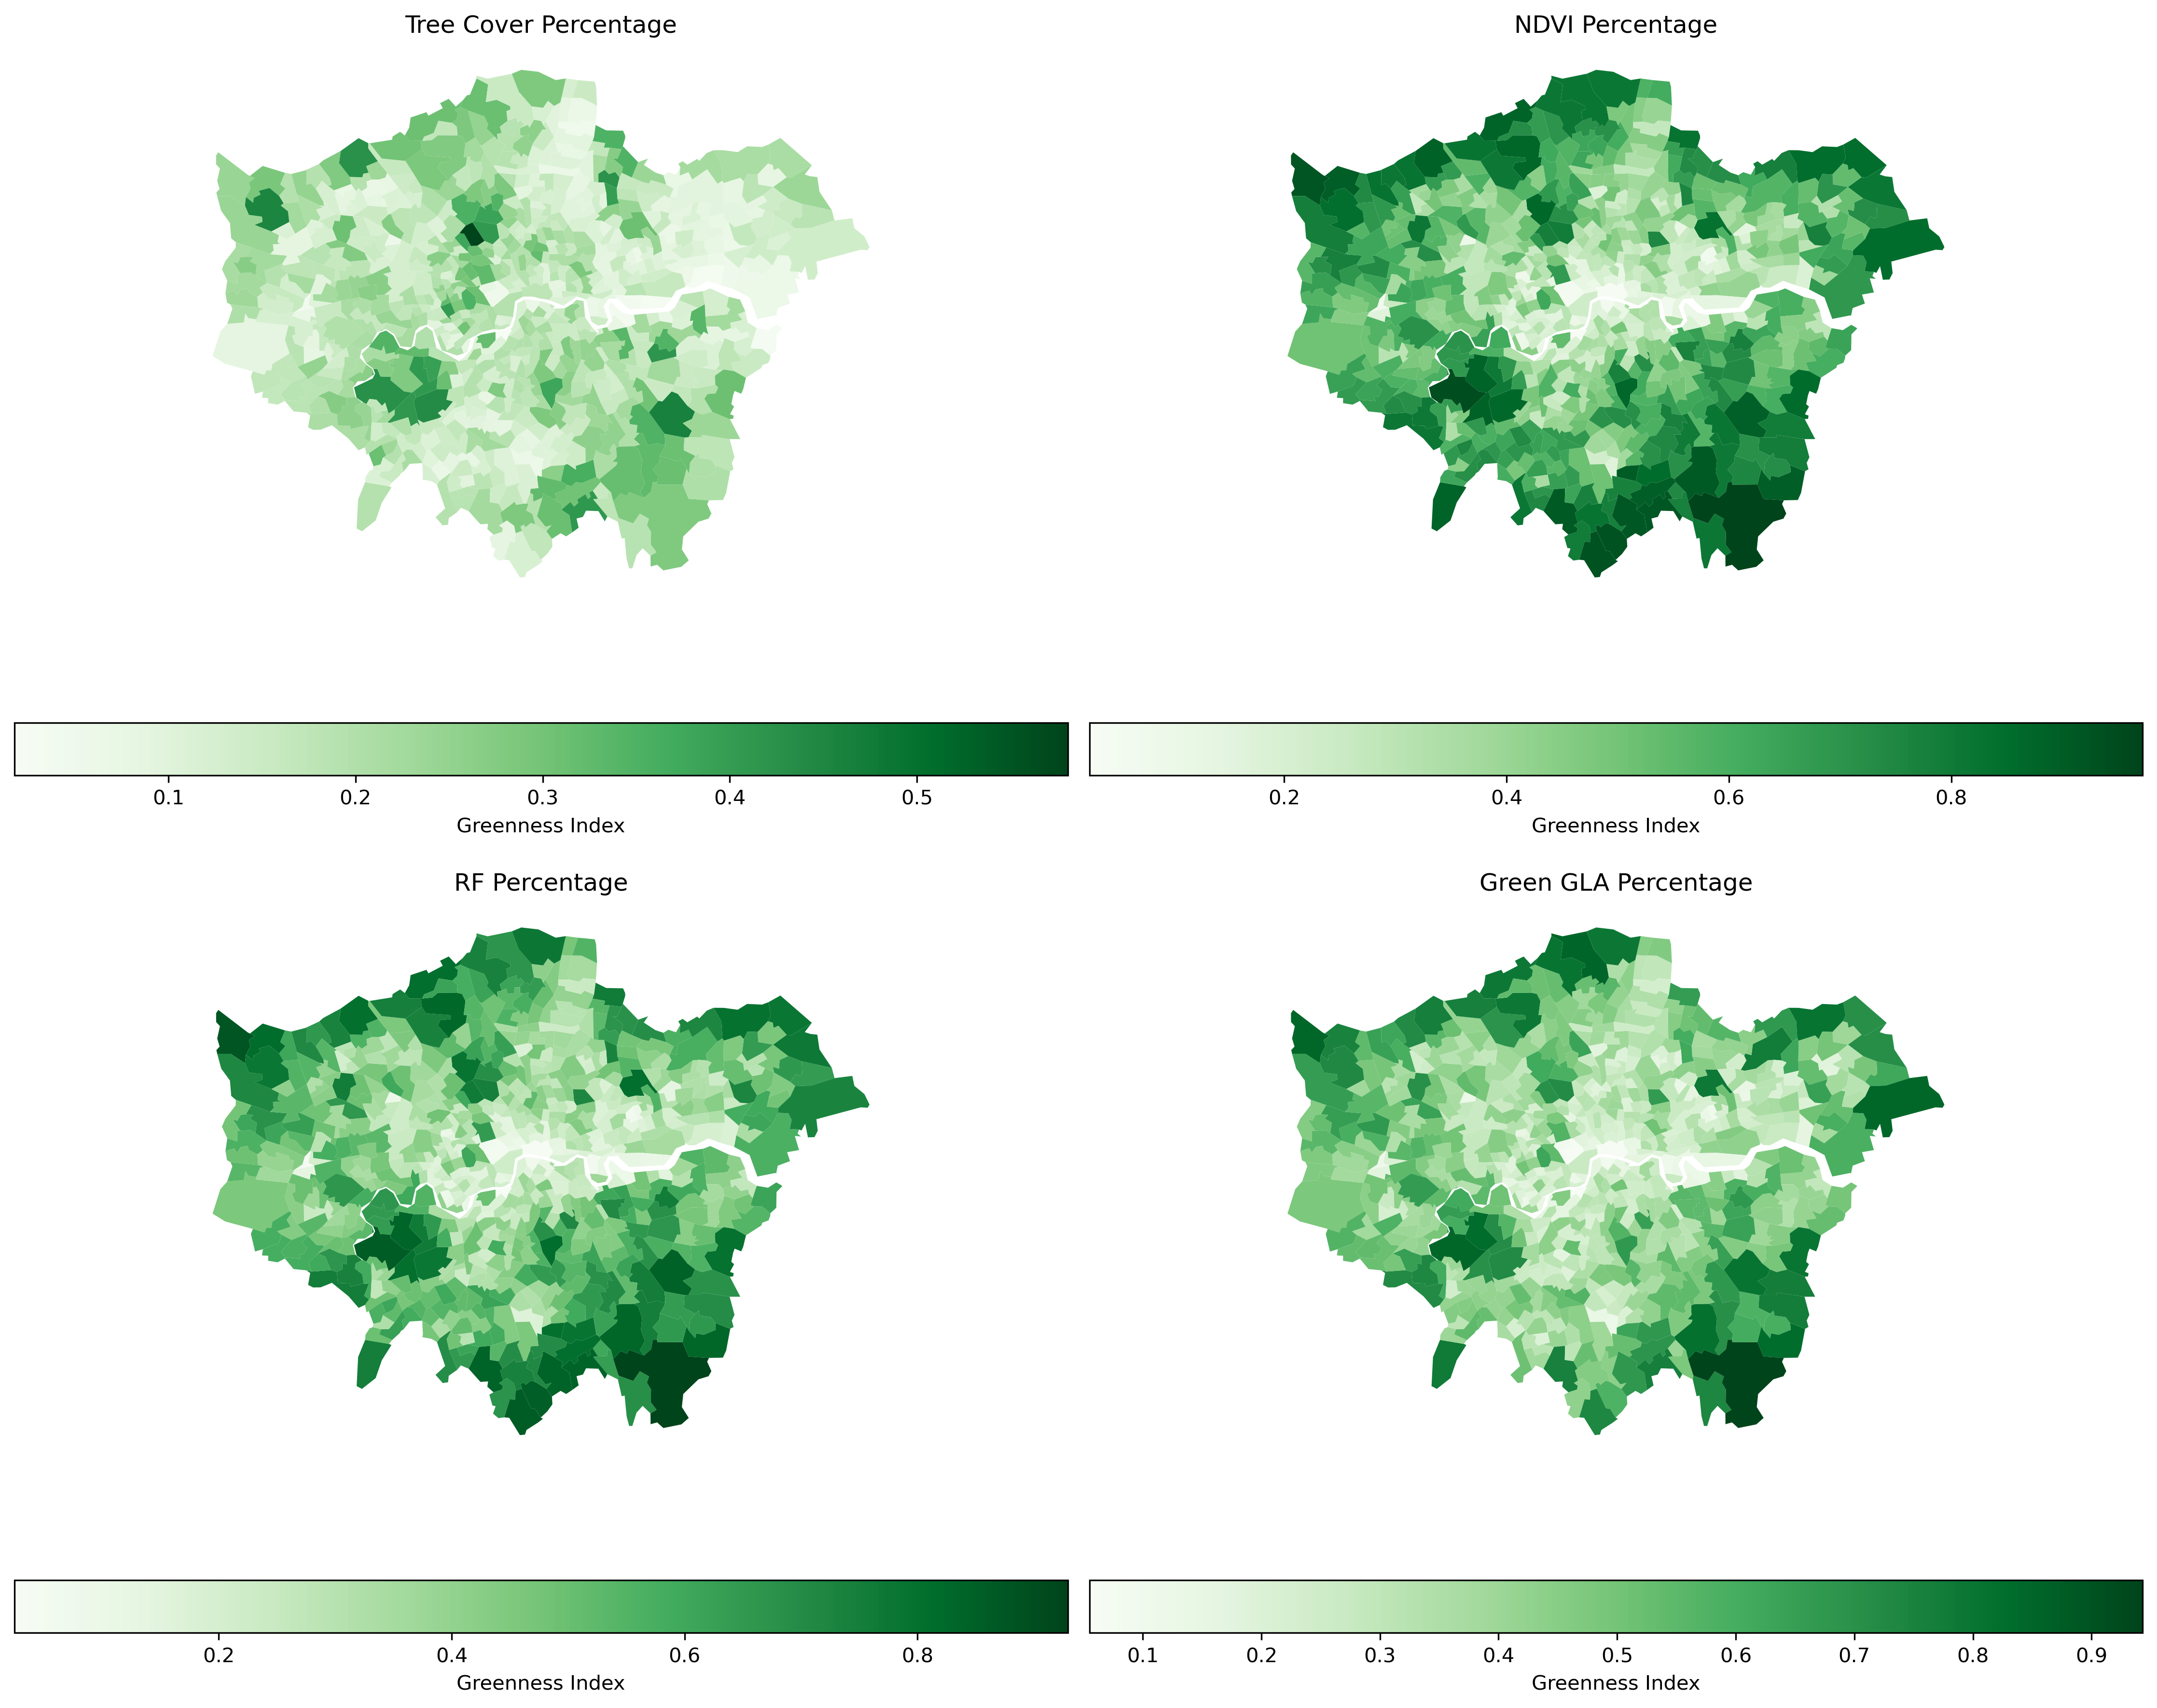

In [17]:

def categorize_crimes(data):
    bins = pd.qcut(data, 5, labels=False, duplicates='drop')  # Use quantile-based discretization
    return bins


fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
titles = ['Tree Cover Percentage', 'NDVI Percentage', 'RF Percentage', 'Green GLA Percentage']
columns = ['tree_cover_percentage', 'percentage_NDVI', 'percentage_RF', 'green_percentage_GLA']
cmap = 'Greens'

for ax, title, column in zip(axes.flatten(), titles, columns):
    merged_data.plot(column=column, ax=ax, cmap=cmap, legend=True,
                     legend_kwds={'label': "Greenness Index", 'orientation': "horizontal"})
    ax.set_title(title)
    ax.set_axis_off()

plt.tight_layout()
plt.savefig('GREEN_SPACE_maps.png')  # Save the figure to a file
plt.show()

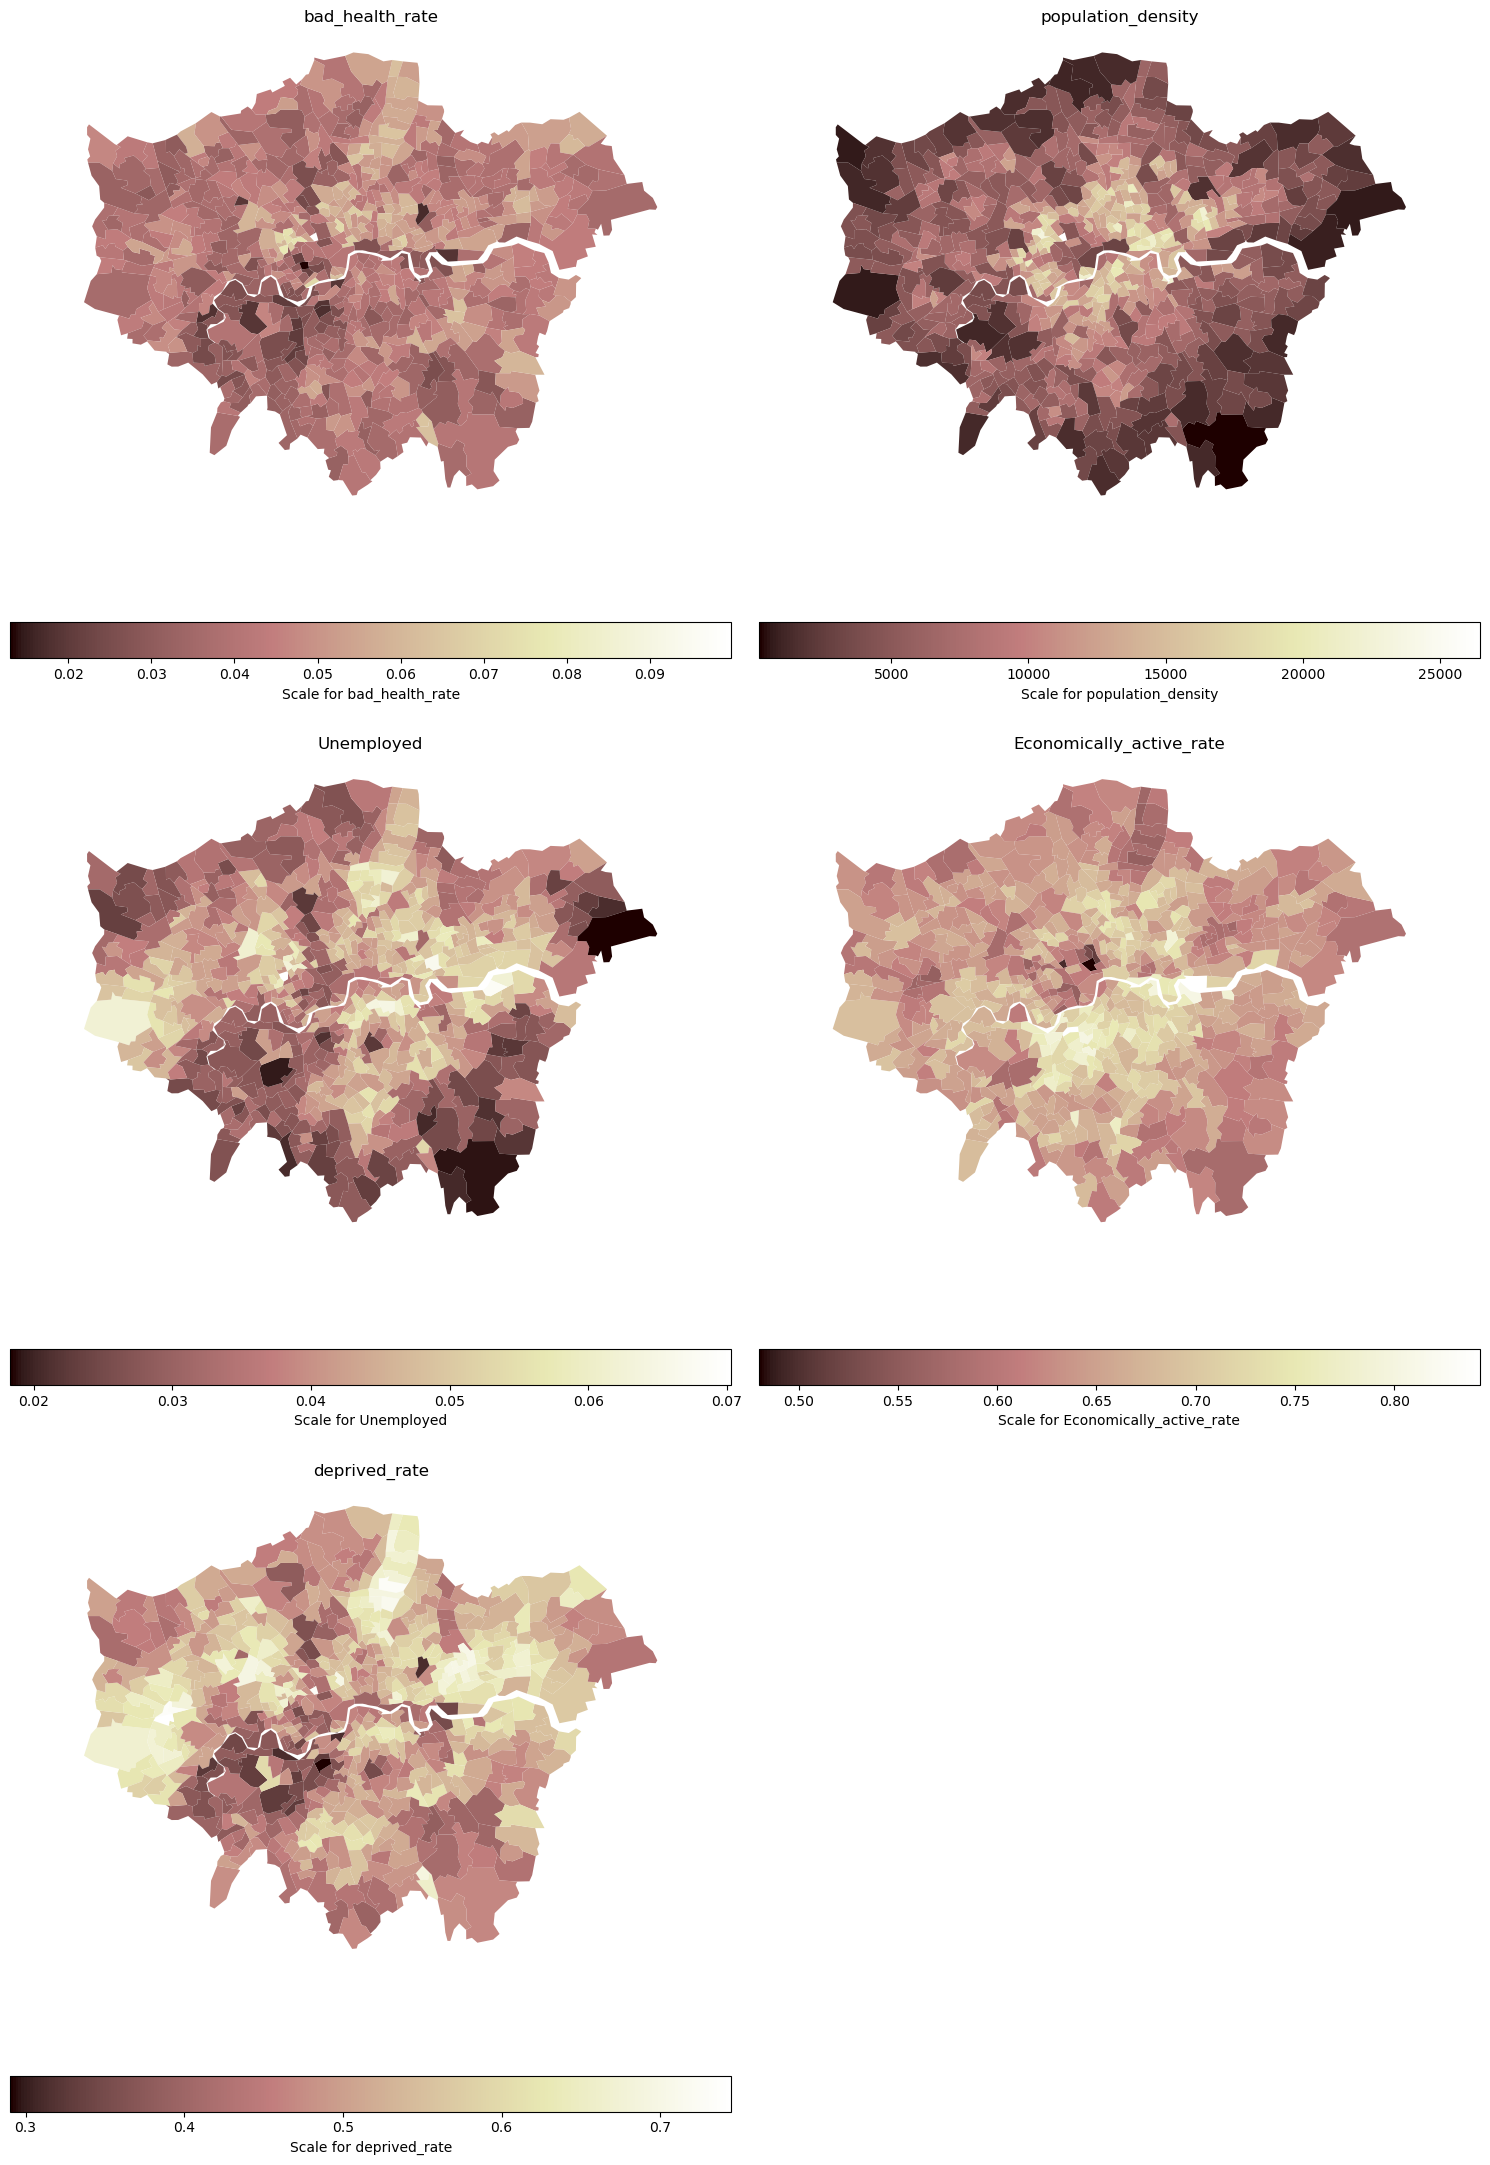

In [18]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


url = "https://raw.githubusercontent.com/parorrr/04/main/data/2.shp"  # Example URL, replace with your actual file location
gdf = gpd.read_file(url)
data = pd.read_csv('final_merged_data.csv')


merged_data = gdf.merge(data, on='WD22CD')  # Assuming 'WD22CD' is the common column


variables = ['bad_health_rate', 'population_density', 'Unemployed', 'Economically_active_rate', 'deprived_rate']


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 22))  
axs = axs.flatten()  


for ax, var in zip(axs, variables):
    merged_data.plot(column=var, ax=ax, legend=True,
                     legend_kwds={'label': "Scale for " + var, 'orientation': "horizontal"},
                     cmap='pink')  # Change colormap as necessary
    ax.set_title(var)
    ax.set_axis_off()


for i in range(len(variables), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.savefig('Social_maps.png')  

plt.show()


       Property_Crime  Public_Order_Offences  Violent_Crime  Total_Crimes  \
count      680.000000             680.000000     680.000000    680.000000   
mean       572.988235             173.657353     421.195588   1167.841176   
std        665.235458             221.558648     424.738351   1242.578893   
min         81.000000              22.000000      61.000000    177.000000   
25%        330.000000              92.000000     248.000000    676.750000   
50%        461.500000             147.500000     371.000000    998.000000   
75%        636.500000             204.000000     517.000000   1338.750000   
max      11641.000000            4950.000000    9460.000000  23482.000000   

       bad_health_rate  population_density  Unemployed  \
count       680.000000          680.000000  680.000000   
mean          0.042476         8703.042794    0.040503   
std           0.010607         4863.122218    0.009871   
min           0.012970          171.500000    0.018286   
25%           0.

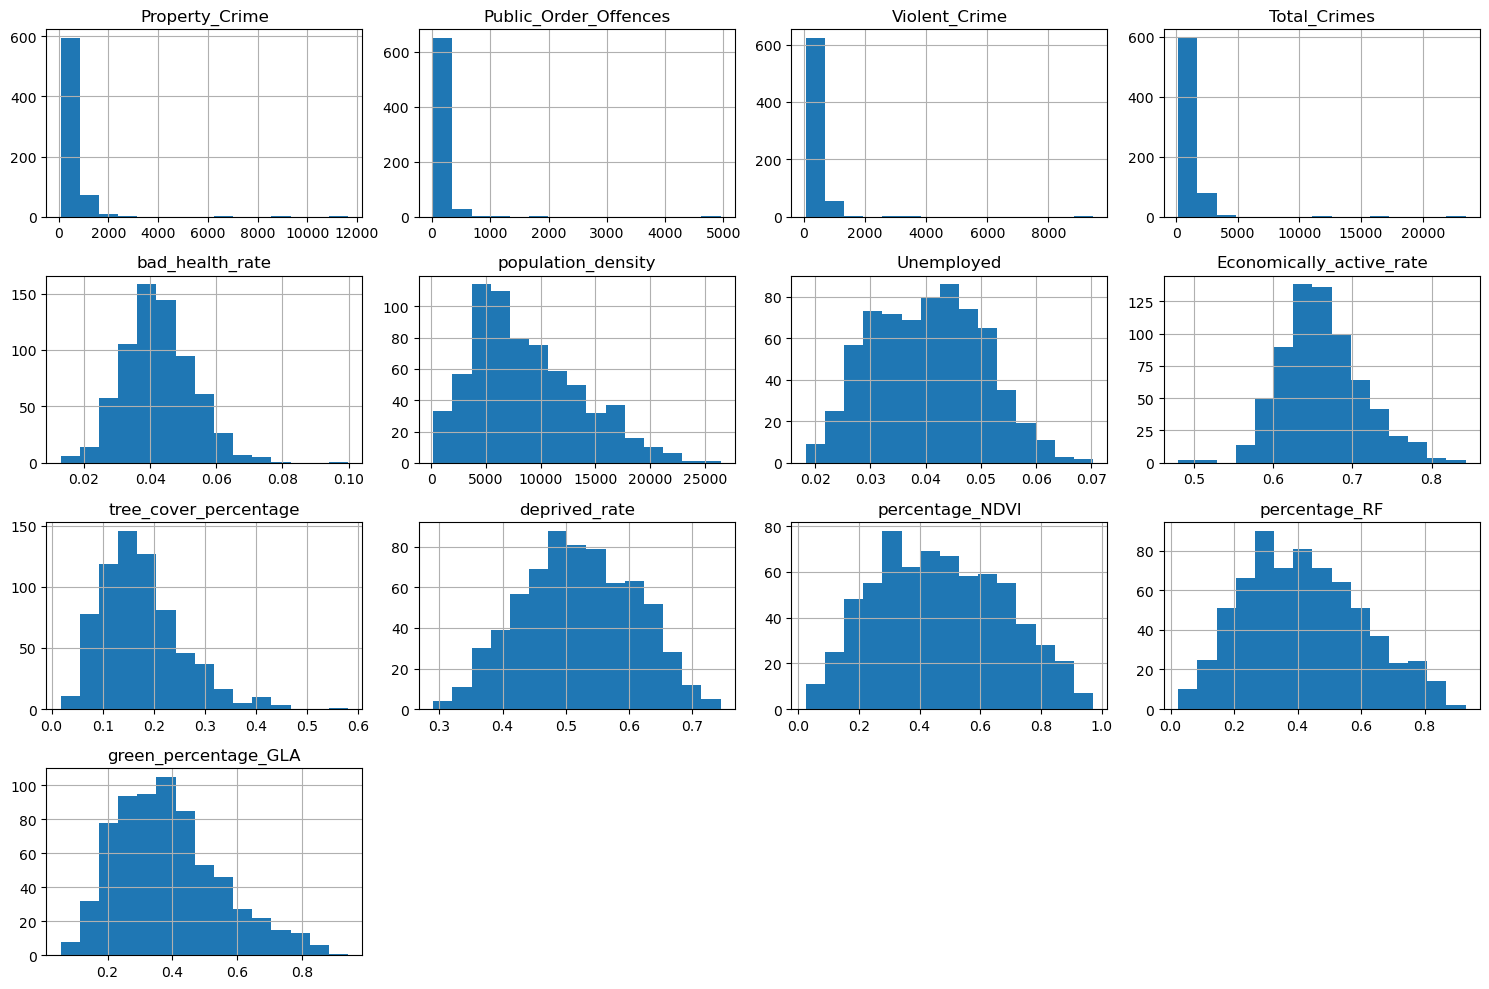

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('final_merged_data.csv')

print(data.describe())

data.hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.tight_layout()
plt.show()



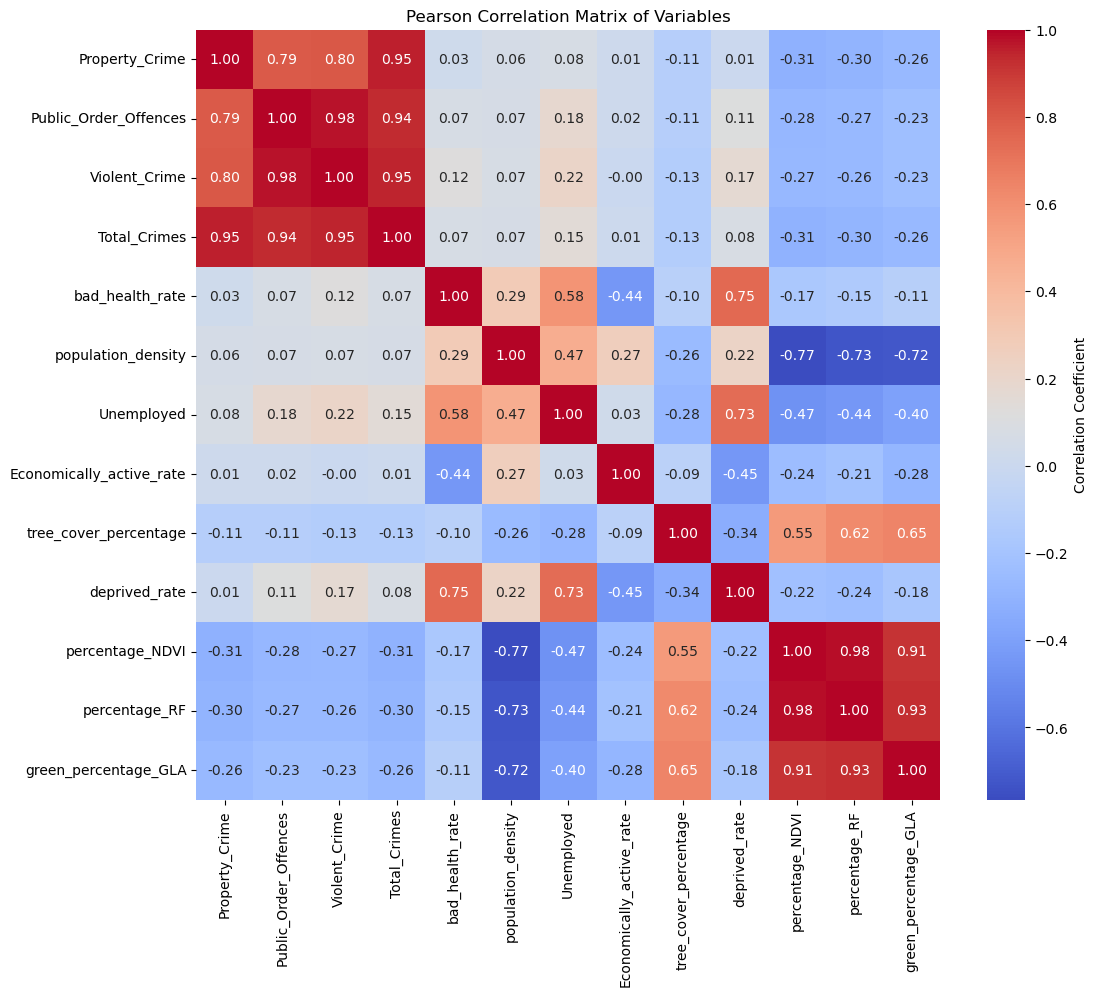

In [20]:
import pandas as pd

data = pd.read_csv('final_merged_data.csv')

data = data.drop(columns=['WD22CD', 'WardName'])

correlation_matrix = data.corr(method='pearson')


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Pearson Correlation Matrix of Variables')
plt.show()


In [21]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf


def fit_negative_binomial(dependent_var, green_space, df):
    formula = f'{dependent_var} ~ {green_space} + bad_health_rate + population_density + Unemployed + Economically_active_rate + deprived_rate'
    model = smf.glm(
        formula=formula,
        data=df,
        family=sm.families.NegativeBinomial()
    ).fit()
    
    return model.summary()

green_spaces = ['tree_cover_percentage', 'percentage_NDVI', 'percentage_RF', 'green_percentage_GLA']
crime_types = ['Total_Crimes', 'Property_Crime', 'Public_Order_Offences', 'Violent_Crime']

results = {}

for green_space in green_spaces:
    for crime_type in crime_types:
        
        result_key = f'{green_space}_{crime_type}'
        results[result_key] = fit_negative_binomial(crime_type, green_space, final_merged_data)

for key, result in results.items():
    print(f"Results for {key}:")
    print(result)



Results for tree_cover_percentage_Total_Crimes:
                 Generalized Linear Model Regression Results                  
Dep. Variable:           Total_Crimes   No. Observations:                  680
Model:                            GLM   Df Residuals:                      673
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5467.3
Date:                Fri, 23 Aug 2024   Deviance:                       207.89
Time:                        15:02:51   Pearson chi2:                     706.
No. Iterations:                    10   Pseudo R-squ. (CS):            0.04533
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/conda/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha no

In [22]:
print(gdf.columns)


Index(['WD22CD', 'WD22NM', 'WD22NMW', 'LAD22CD', 'LAD22NM', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'GlobalID', 'layer', 'path', 'geometry'],
      dtype='object')


In [23]:
import geopandas as gpd
import pandas as pd


url = "https://raw.githubusercontent.com/parorrr/04/main/data/2.shp"
gdf = gpd.read_file(url)


data = pd.read_csv('final_merged_data.csv')


print(gdf.columns)
print(data.columns)


merged_data = gdf.merge(data, on='WD22CD')

print(merged_data.columns)


print(merged_data['Property_Crime'].head())


Index(['WD22CD', 'WD22NM', 'WD22NMW', 'LAD22CD', 'LAD22NM', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'GlobalID', 'layer', 'path', 'geometry'],
      dtype='object')
Index(['WD22CD', 'WardName', 'Property_Crime', 'Public_Order_Offences',
       'Violent_Crime', 'Total_Crimes', 'bad_health_rate',
       'population_density', 'Unemployed', 'Economically_active_rate',
       'tree_cover_percentage', 'deprived_rate', 'percentage_NDVI',
       'percentage_RF', 'green_percentage_GLA'],
      dtype='object')
Index(['WD22CD', 'WD22NM', 'WD22NMW', 'LAD22CD', 'LAD22NM', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'GlobalID', 'layer', 'path', 'geometry', 'WardName',
       'Property_Crime', 'Public_Order_Offences', 'Violent_Crime',
       'Total_Crimes', 'bad_health_rate', 'population_density', 'Unemployed',
       'Economically_active_rate', 'tree_cover_percentage', 'deprived_rate',
       'percentage_NDVI', 'percentage_RF', 'green_percentage_GLA'],
      dtype='object')
0    1102.0
1     681.0
2    1

In [24]:

import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

merged_data = merged_data.set_geometry('geometry')
merged_data = merged_data.to_crs(epsg=27700) 

coords = np.column_stack([merged_data['geometry'].centroid.x, merged_data['geometry'].centroid.y])

X = merged_data[[ 'population_density', 'Unemployed',
                 'Economically_active_rate', 'bad_health_rate', 'deprived_rate',
                 'percentage_NDVI']].astype(float).values

y = merged_data['Property_Crime'].values.reshape((-1, 1)).astype(float)

bw = Sel_BW(coords, y, X, fixed=False, kernel='bisquare').search()


print(f'Optimal bandwidth: {bw}')

gwr_results = GWR(coords, y, X, bw, fixed=False, kernel='bisquare', constant=True, spherical=True).fit()


/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

Optimal bandwidth: 71.0


In [25]:
gwr_results.summary() #in this point we should install the NumPy 1.23.5.ver

Model type                                                         Gaussian
Number of observations:                                                 680
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       242539901.784
Log-likelihood:                                                   -5311.637
AIC:                                                              10637.274
AICc:                                                             10639.488
BIC:                                                           242535512.416
R2:                                                                   0.193
Adj. R2:                                                              0.186

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ----

In [26]:
print(final_merged_data.info())    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   WD22CD                    680 non-null    object 
 1   WardName                  680 non-null    object 
 2   Property_Crime            680 non-null    float64
 3   Public_Order_Offences     680 non-null    float64
 4   Violent_Crime             680 non-null    float64
 5   Total_Crimes              680 non-null    int64  
 6   bad_health_rate           680 non-null    float64
 7   population_density        680 non-null    float64
 8   Unemployed                680 non-null    float64
 9   Economically_active_rate  680 non-null    float64
 10  tree_cover_percentage     680 non-null    float64
 11  deprived_rate             680 non-null    float64
 12  percentage_NDVI           680 non-null    float64
 13  percentage_RF             680 non-null    float64
 14  green_perc

In [29]:
import geopandas as gpd
import pandas as pd

url = "https://raw.githubusercontent.com/parorrr/04/main/data/2.shp"  # Example URL, replace with your actual file location
shp_data = gpd.read_file(url)
csv_data = pd.read_csv('final_merged_data.csv')



merged_data = shp_data.merge(csv_data, left_on='WD22CD', right_on='WD22CD', how='inner')


var_names = ['cof_Intercept', 'cof_population_density', 'cof_unemployed', 'cof_Economically_active_rate', 'cof_bad_health_rate', 'cof_deprived_rate', 'cof_percentage_NDVI']
gwr_coefficient = pd.DataFrame(gwr_results.params, columns=var_names)

gwr_tvalues = pd.DataFrame(gwr_results.filter_tvals(), columns=var_names)

for col in var_names:
    merged_data[col] = gwr_coefficient[col]
    merged_data[col + '_t'] = gwr_tvalues[col]

merged_data.to_file('result_shapefile.shp')


/tmp/ipykernel_48610/399120611.py:22: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_data.to_file('result_shapefile.shp')


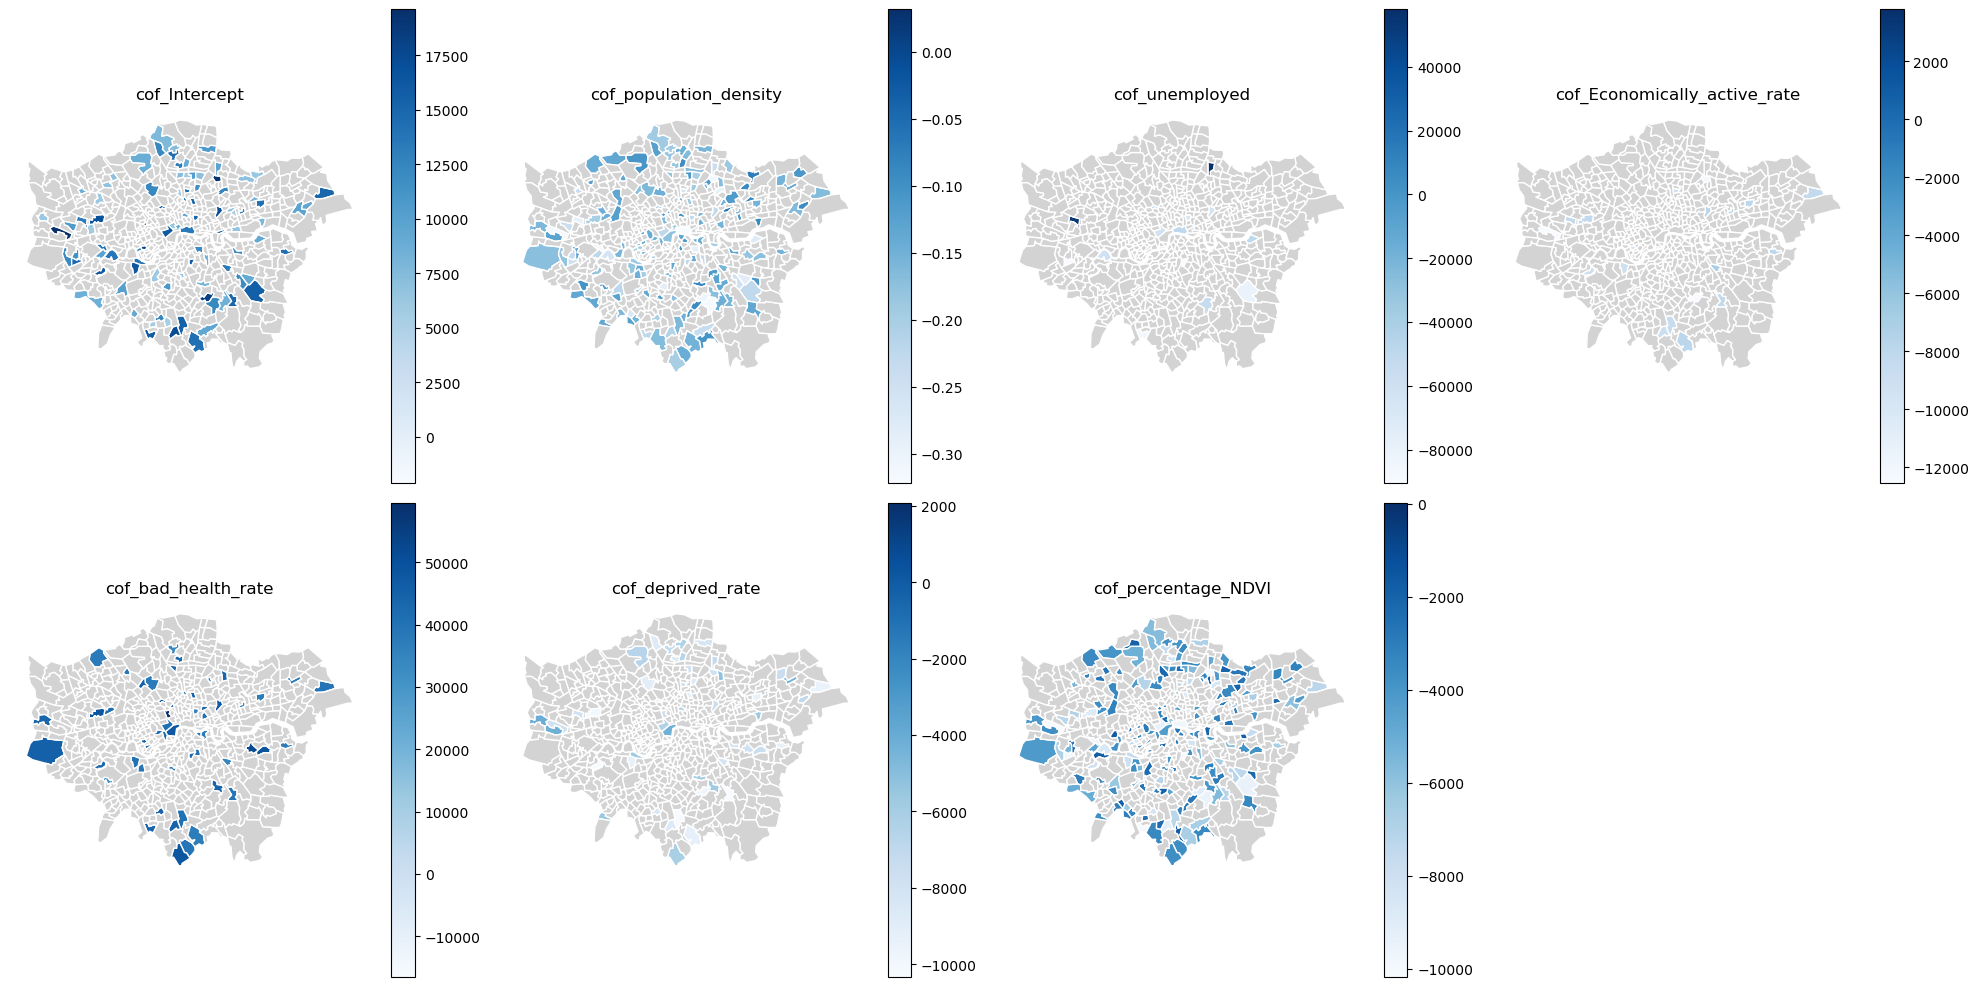

In [30]:
import matplotlib.pyplot as plt
import geopandas as gpd

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  
axes = axes.flatten()

for i, var in enumerate(var_names):
    ax = axes[i]
    ax.set_title(var)
    merged_data.plot(ax=ax, column=var, edgecolor='white', cmap='Blues', legend=True)
    

    insignificant = (gwr_tvalues[var] == 0) 
    merged_data.loc[insignificant].plot(color='lightgrey', ax=ax, edgecolor='white')  

    ax.set_axis_off()
    if i+1==7:
        axes[7].axis('off')
        
plt.tight_layout()
plt.show()

